In [2]:
import os
import cmdstanpy as stan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import pickle
import arviz as az
from scipy.special import expit

In [3]:
%load_ext stanmagic

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set() 

# Toy model

## Data

[]

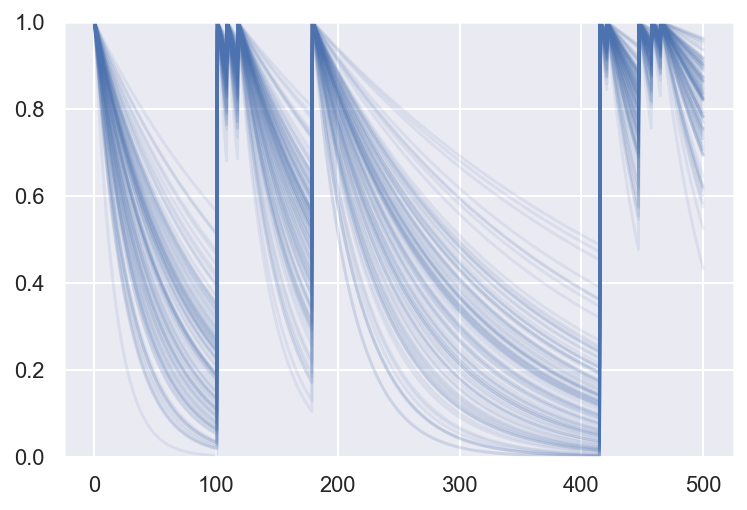

In [5]:
theta1 = np.random.normal(-4, 0.5, size=100)
theta2 = np.random.normal(-2, 0.4, size=100)

max_t = 5* 10**2
n_pres = 10

x = np.linspace(0, max_t, 1000)
pres = np.concatenate(([0,], np.sort(np.random.uniform(0, max_t, n_pres-1))))

n = np.zeros(x.shape)

delta = np.zeros(x.shape)
for i, p in enumerate(pres):
    delta[x>p] = x[x>p] - p
    n[x>p] = i
fig, ax = plt.subplots()

for th1, th2 in zip(theta1, theta2):
    alpha, beta = np.exp(th1), expit(th2)
    # print("alpha-beta", alpha, beta)
    p = np.exp(-alpha*(1-beta)**n*delta)
    ax.plot(x, p, color='C0', alpha=0.1)
ax.set_ylim(0, 1)
plt.plot()

In [33]:
# Seed
np.random.seed(123)


sg_u = 0.1, 0.1
sg_w = 0.5, 0.3

sg_theta = (0.001, 0.001)

mu = (-4, 0.3)
n_param = 2

# Number of users
n_u = 20
# Number of words
n_w = 10
# Number of obs
n_o = 10

t_max = 100

# Number of words seen by a single user
n_w_by_u = np.random.randint(3, 5, n_u)

U = np.random.normal(0, sg_u, size=(n_u, n_param))   # User ability
W = np.random.normal(0, sg_w, size=(n_w, n_param))   # Item difficulty
rd = np.random.normal(size=(n_u, n_o))

words = np.zeros(shape=(n_u, n_o), dtype=int)
delta = np.random.uniform(0, t_max, size=(n_u, n_o))
n_rep = np.zeros(shape=(n_u, n_o), dtype=int)
y = np.zeros(shape=(n_u, n_o), dtype=int)

for u in range(n_u):
    seen = np.random.choice(np.arange(n_w), replace=False, size=n_w_by_u[u])
    words[u] = np.random.choice(seen, replace=True, size=n_o)
    counts = {word: 0 for word in seen}
    for i, word in enumerate(words[u]):
        n_rep[u, i] = counts[word]
        counts[word] += 1
    mu_u = mu + U[u] + W[words[u]]
    theta = np.random.normal(mu_u, sg_theta)
    a = np.exp(theta[:, 0])
    b = expit(theta[:, 1])
    exponent = - a *(1-b)**n_rep[u] * delta[u]
    p = np.exp(exponent)
    y[u] = p > rd[u]

data = {'n_u': n_u, 'n_w': n_w,  'n_o': n_o, 'delta': delta, 'n_rep': n_rep, 'y': y, 
        'words': words+1} # Stan index starts from 1

In [34]:
print(np.mean(p), np.max(p), np.min(p))
print(np.mean(y), np.min(y), np.max(y))

0.7517633290451922 0.9892687166110814 0.06696606718788783
0.765 0 1


# Model

In [35]:
%%stan -f model2paramIncmp.stan -v model2paramIncmp --stanc ~/.cmdstan/cmdstan-2.26.1/bin/stanc
data {
  int<lower=0> n_u;    
  int<lower=0> n_w;  
  int<lower=0> n_o;  
  real delta[n_u, n_o];
  int n_rep[n_u, n_o];
  int y[n_u, n_o];
  int words[n_u, n_o];
}
transformed data {
}
parameters {
  real<lower=0> sg_u1;
  real<lower=0> sg_w1;
  real<lower=0> sg_theta1;
  real mu1;
  real<lower=0> sg_u2;
  real<lower=0> sg_w2;
  real<lower=0> sg_theta2;
  real mu2;
  
  real U1[n_u];
  real W1[n_w];
  real theta1_wu[n_u, n_o];
  real U2[n_u];
  real W2[n_w];
  real theta2_wu[n_u, n_o];
}
model {
  vector[n_o] a;
  vector[n_o] b;
  vector[n_o] rate;
  vector[n_o] exponent;
  vector[n_o] p;
  vector[n_o] p_suc;
  vector[n_o] log_p;
  vector[n_o] y_arr;
  vector[n_o] delta_arr;
  vector[n_o] n_rep_arr;
  vector[n_o] mu1_u;
  vector[n_o] mu2_u;
  int words_u[n_o];
  
  sg_w1 ~ inv_gamma(1, 1);
  sg_u1 ~ inv_gamma(1, 1);
  sg_theta1 ~ inv_gamma(1, 1);
  mu1 ~ normal(0, 10);
  U1 ~ normal(0, sg_u1);
  W1 ~ normal(0, sg_w1);
  
  sg_w2 ~ inv_gamma(1, 1);
  sg_u2 ~ inv_gamma(1, 1);
  sg_theta2 ~ inv_gamma(1, 1);
  mu2 ~ normal(0, 10);
  U2 ~ normal(0, sg_u2);
  W2 ~ normal(0, sg_w2);

  for (u in 1:n_u) {
    words_u = words[u];
    mu1_u = rep_vector(mu1 + U1[u], n_o) + to_vector(W1[words_u]);
    mu2_u = rep_vector(mu2 + U2[u], n_o) + to_vector(W2[words_u]);
    theta1_wu[u] ~ normal(mu1_u, sg_theta1);
    theta2_wu[u] ~ normal(mu2_u, sg_theta2);
    a = exp(to_vector(theta1_wu[u]));
    b = inv_logit(to_vector(theta2_wu[u]));
    n_rep_arr = to_vector(n_rep[u]);
    delta_arr = to_vector(delta[u]);
    y_arr = to_vector(y[u]);
    exponent = - a .* pow(1-b, n_rep_arr) .* delta_arr;
    p_suc = exp(exponent);
    p = pow(p_suc, y_arr) .* pow(1-p_suc, 1-y_arr);
    log_p = log(p);
    target += sum(log_p);
  }
}

Using stanc compiler:  ~/.cmdstan/cmdstan-2.26.1/bin/stanc
~/.cmdstan/cmdstan-2.26.1/bin/stanc --o=/var/folders/yg/spp3n_c56vxbgvjy9wthwy_h0000gn/T/62c80142-2b56-4c89-8c5b-c5db346e01c7.cpp model2paramIncmp.stan

-------------------------------------------------------------------------------
Model compiled successfully. Output stored in model2paramIncmp object.
Type model2paramIncmp in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^^^^
Access model compile output properties
model2paramIncmp.model_file -> Name of stan_file [model2paramIncmp.stan]
model2paramIncmp.model_name -> Name of stan model [model2paramIncmp_model]
model2paramIncmp.model_code -> Model code [data {   int<lower=0 ....]


In [ ]:
m = stan.CmdStanModel(stan_file=model2paramIncmp.model_file)

INFO:cmdstanpy:compiling stan program, exe file: /Users/aureliennioche/Documents/PythonProjects/ActiveTeachingCollaborative/model2paramIncmp
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None


In [ ]:
trace = m.sample(data=data, show_progress="notebook")

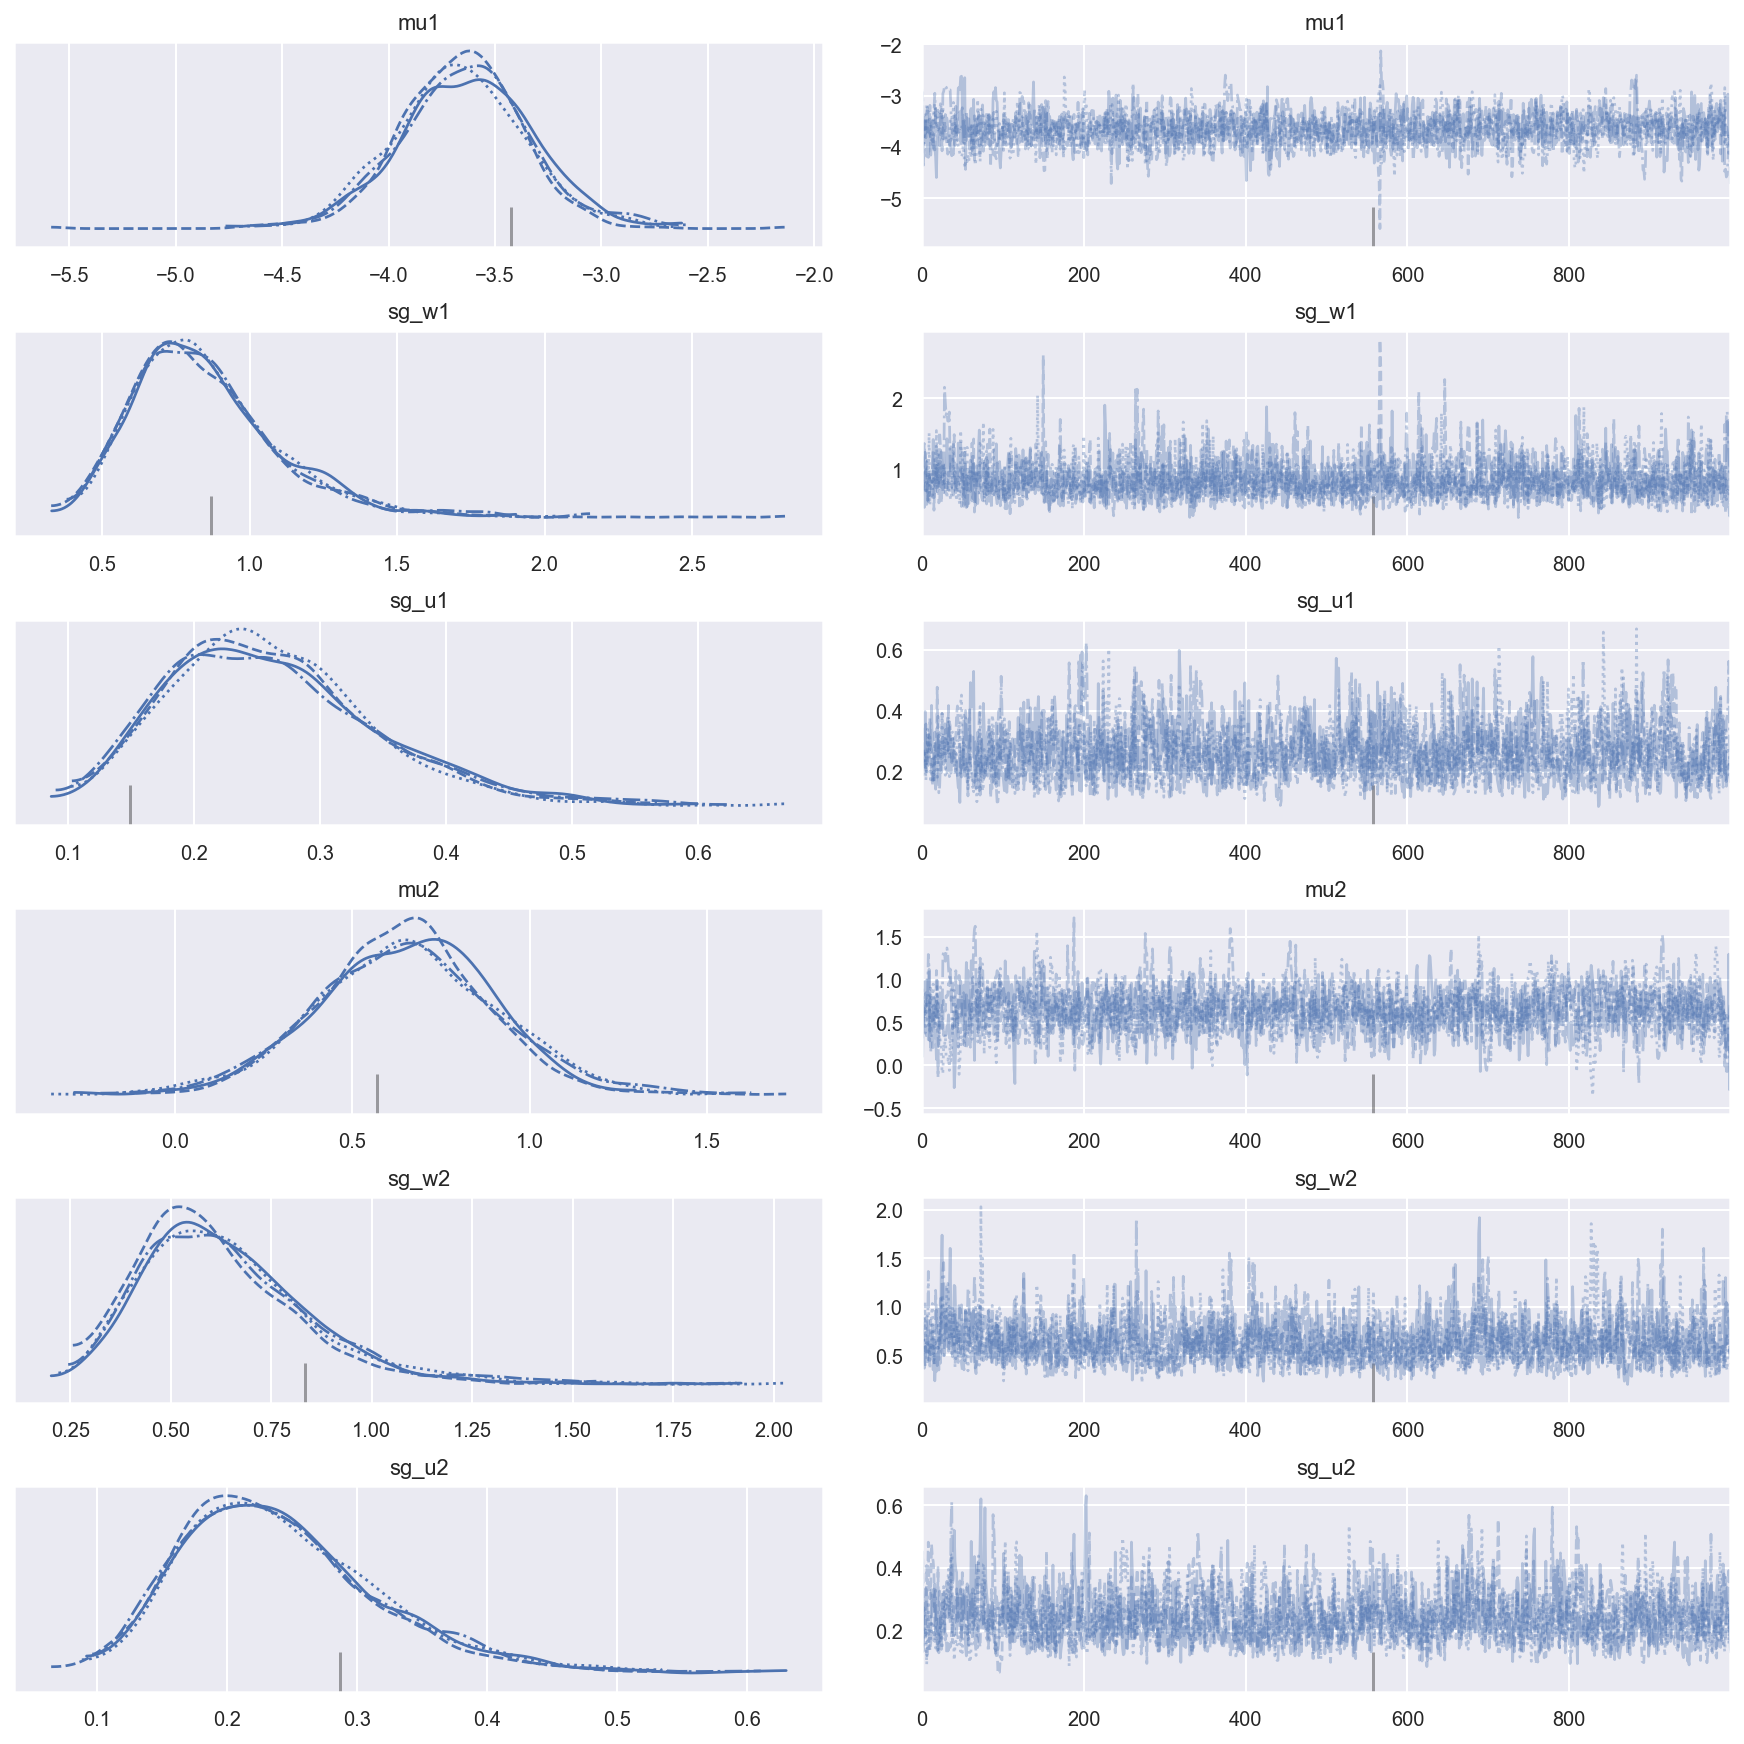

In [14]:
az.plot_trace(trace, var_names=['mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2']);

## MLE

In [97]:
%%time
mp = m.optimize(data=data, algorithm='BFGS', seed=1)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


CPU times: user 9.56 ms, sys: 15.7 ms, total: 25.3 ms
Wall time: 16.7 s


In [98]:
for var in 'mu1', 'sg_w1', 'sg_u1', 'mu2', 'sg_w2', 'sg_u2':
    print(var, mp.optimized_params_dict[var])

mu1 -3.71732
sg_w1 0.524009
sg_u1 0.0462797
mu2 0.398964
sg_w2 0.137825
sg_u2 0.0462345
